# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import random
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter
from datetime import datetime

from torchvision import models, transforms

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
base_path = "/mnt/SoilEstimation/"

hsi_path = base_path + 'train_data/1570.npz'
gt_path = base_path + 'train_gt.csv'
wavelength_path = base_path + 'wavelengths.csv'

In [3]:
use_AdamW = True # Flag utilized for switching between AdamW and SGD optimizer.

if use_AdamW:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':75,
            
            # Settings for the optimizer AdamW
            'lr':5e-4, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }
else:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':100,

            # Settings for the optimizer SGD
            'lr':1e-4, # learning rate
            'weight_decay':5e-4,  
            'momentum':0.9,

            # Settings for the lr_scheduler MultiStepLR
            'milestones':[50,75,90], # List of epoch indices.
            'gamma':0.2, # Multiplicative factor of learning rate decay.
          }

In [4]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [6]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [7]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

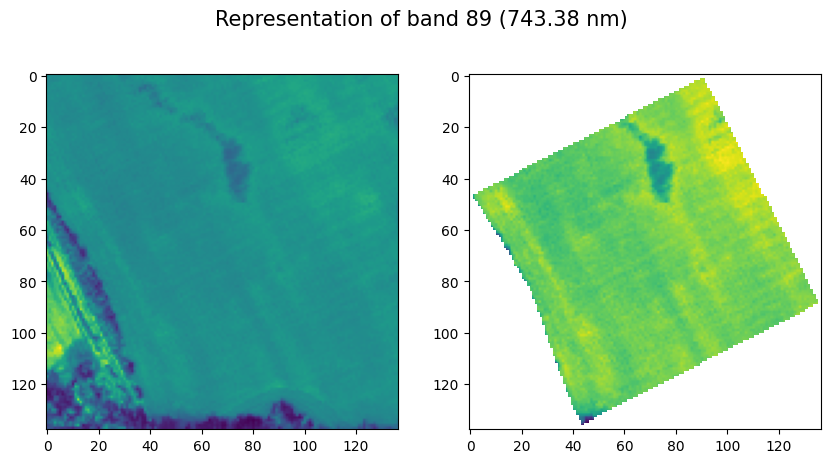

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 89
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

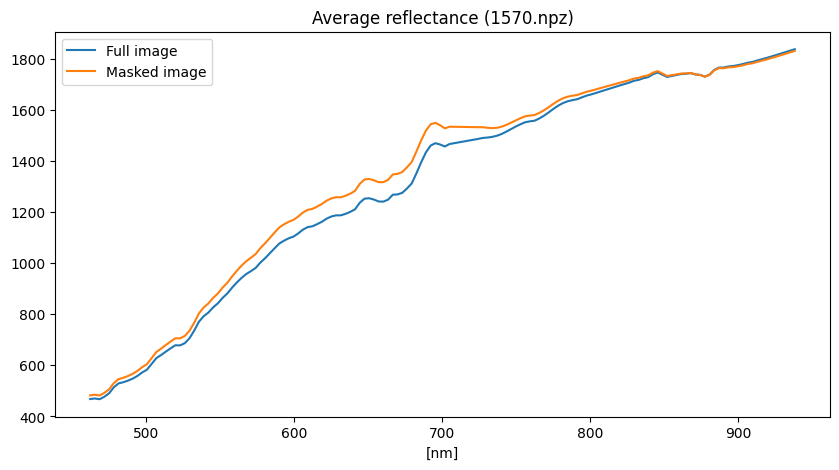

In [9]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Generating baseline solution

In [10]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)
    

class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [11]:
num_classes = 4
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
#model = models.resnet50(weights="DEFAULT")
model = models.quantization.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)


#model = ResNet152(num_classes)
model.to(device)

QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [12]:
criterion = nn.MSELoss()

# Experiment with various optimizers and schedulers.
if use_AdamW: 
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])

## Load the data

In [13]:
import os
from glob import glob
from torchvision.transforms.functional import to_pil_image

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            
            arr = npz['data'][[0,75,-1],:,:]
            mask = npz["mask"][[0,75,-1],:,:]

            # arr = npz['data']
            # mask = npz["mask"]

            
            arr = torch.tensor(arr, dtype=torch.float32)
            mask = torch.tensor(~mask, dtype=torch.float32)
            
            transformer = transforms.Resize((128,128), antialias=True)

            arr = transformer(arr)
            mask = transformer(mask)

            arr = arr * mask
            
        #arr = filtering(arr)
        data.append(arr)
    return data


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


In [14]:
X_train = load_data(base_path + "train_data")
y_train = load_gt(base_path + "train_gt.csv")
X_test = load_data(base_path + "test_data")

In [15]:
tensor_x = torch.stack(X_train)
tensor_y = torch.Tensor(y_train)

batch_size = tensor_x.size(0)

print(tensor_x.shape)
print(tensor_y.shape)


torch.Size([1732, 3, 128, 128])
torch.Size([1732, 4])


In [16]:
from torch.utils.data import TensorDataset, DataLoader

dataset=TensorDataset(tensor_x,tensor_y)

n = int(len(tensor_x) * config['tr_val_split'])
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=True) 

test_x = torch.stack(X_test)
testset=TensorDataset(test_x)

test_dataloader= DataLoader(testset,shuffle=False)

## Make predictions and generate submission file

In [17]:
def train_one_epoch(model):
    running_loss = 0.
    num_samples = 0

    for _, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_samples += inputs.size(0)
        
    train_loss = running_loss / len(train_dataloader)

    return train_loss

In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
def train(model,path):
        # Initializing in a separate cell so we can easily add more epochs to the same run
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('./eurosat_trainer_{}'.format(timestamp))
    epoch_number = 0
    tr_acc = 0.0
    best_vloss = 1_000_000.

    for epoch in range(config['epochs']):
        print('============= EPOCH {} ============='.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model)

        running_vloss = 0.0
        val_acc = 0.0
        num_vcorrect = 0
        num_vsamples = 0

        # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs.to(device))
                vloss = criterion(voutputs, vlabels.to(device))
                running_vloss += vloss
                _, vpredictions = voutputs.max(dim=-1)

        avg_vloss = running_vloss / len(val_dataloader)
        print('LOSS : train {} | valid {}'.format(round(avg_loss, 4), round(avg_vloss.item(), 4)))

        # Log the running loss averaged per epoch for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), path)

        epoch_number += 1

In [19]:
train(model,"./model")

============= EPOCH 1 =============


LOSS : train 21120.0742 | valid 18307.6758
============= EPOCH 2 =============
LOSS : train 16589.2021 | valid 12468.042
============= EPOCH 3 =============
LOSS : train 12880.4523 | valid 9598.3193
============= EPOCH 4 =============
LOSS : train 9709.4665 | valid 7167.8672
============= EPOCH 5 =============
LOSS : train 7239.5202 | valid 5408.6421
============= EPOCH 6 =============
LOSS : train 5397.8274 | valid 4097.9883
============= EPOCH 7 =============
LOSS : train 3879.898 | valid 3203.8467
============= EPOCH 8 =============
LOSS : train 2942.2922 | valid 2252.4153
============= EPOCH 9 =============
LOSS : train 2350.5999 | valid 1863.8362
============= EPOCH 10 =============
LOSS : train 2108.4739 | valid 1757.6373
============= EPOCH 11 =============
LOSS : train 1931.777 | valid 1692.4255
============= EPOCH 12 =============
LOSS : train 1799.3285 | valid 1603.5426
============= EPOCH 13 =============
LOSS : train 1666.4515 | valid 1682.7039
============= EPOCH 14 ======

In [20]:
# calibrazione modello
def calibration(model,dataloader):
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            inputs = data[0].to(device)
            model(inputs)

In [21]:
#model_avg_tloss, model_test_acc, model_time = eval_loop(model,test_dataloader)
#print(f"---> Model <---")
#print(f'Loss: {round(model_avg_tloss.item(),4)}')
#print(f'Accuracy: {round(model_test_acc*100,2)}')
#print(f"Time (ns): {model_time}")

device = "cpu"

model=models.quantization.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("./model"))
model.to(device)
model.eval()

model.qconfig = torch.quantization.get_default_qconfig("x86")
model.fuse_model(is_qat=False)
prepared_model = torch.quantization.prepare(model)
#
calibration(prepared_model,train_dataloader)

prepared_model.eval()
quantized_model = torch.quantization.convert(prepared_model)

torch.save(quantized_model.state_dict(), "./quantized_model")

In [22]:
def predict(model):
    model.eval()
    predictions = []  # Inizializza una lista per memorizzare le predizioni
    with torch.no_grad():
        for _, data in enumerate(test_dataloader):
            inputs = data[0].to(device)
            # Effettua le previsioni utilizzando il modello
            outputs = model(inputs)
            # Aggiungi le predizioni alla lista delle predizioni
            predictions.append(outputs.cpu().numpy())

    predictions_array = np.concatenate(predictions)
    submission_df = pd.DataFrame(data=predictions_array, columns=["P", "K", "Mg", "pH"])
    submission_df.to_csv("submission.csv", index_label="sample_index")

In [23]:
def get_model_size(model_path):
    model_path_stat = os.stat(model_path)
    return model_path_stat.st_size

num_classes=4
model=models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("./model"))
model.to(device)
model.eval()

quantized_model=models.quantization.resnet50(quantize=True)
quantized_model.load_state_dict(torch.load("./quantized_model"))
quantized_model.to(device)
quantized_model.eval()

from time import time_ns

start_model = time_ns()
predict(model)
model_time = time_ns() - start_model

start_quantized = time_ns()
predict(quantized_model)
quantized_time = time_ns() -start_quantized

model_size = get_model_size("./model")
quantized_model_size= get_model_size("./quantized_model")
print(f"The quantized model is:") 
print(f"{model_size/quantized_model_size:.2f} times smaller")
print(f"{model_time/quantized_time:.2f} times faster")


/opt/conda/envs/Earth_Observation/lib/python3.10/site-packages/torch/_utils.py:383: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


The quantized model is:
3.99 times smaller
3.81 times faster
